Reading dataset

# Installs

In [1]:
! pip install pandas
! pip install matplotlib
! pip install pandas
! pip install numpy==1.23.5
! pip install scikit-surprise
! pip install scikit-learn
! pip install pyarrow
! pip install tqdm

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build scikit-surprise


  error: subprocess-exited-with-error
  
  × Building wheel for scikit-surprise (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [115 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-310\surprise
      copying surprise\accuracy.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\builtin_datasets.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\dataset.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\dump.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\reader.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\trainset.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\utils.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\__init__.py -> build\lib.win-amd64-cpython-310\surprise
      copying surprise\__main__.py -> build\lib.win-amd64-cpython-310\surpris

# Imports

In [2]:
! pip install pyarrow
! pip install fastparquet
! pip install seaborn

In [3]:
! pip install pandas

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
import numpy as np
import seaborn as sns

# Preprocessing

Forming dataset

In [5]:
smm_train_data = pd.read_parquet('train_smm.parquet')
smm_test_data = pd.read_parquet('test_smm.parquet')
zvuk_train_data = pd.read_parquet('train_zvuk.parquet')
zvuk_test_data = pd.read_parquet('test_zvuk.parquet')

In [6]:
zvuk_train_data['timestamp'] = pd.to_datetime(zvuk_train_data['timestamp'])
smm_train_data['timestamp'] = pd.to_datetime(smm_train_data['timestamp'])

In [7]:
def add_time_features(df):
    df['date'] = df['timestamp'].dt.date
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

zvuk_train_data = add_time_features(zvuk_train_data)
smm_train_data = add_time_features(smm_train_data)

## Фичи с мегамаркетом

### Обработка item_features для мегамаркета + звук

Нормальлизуем рейтинга

In [34]:
def normalize_ratings(df_list):
    combined_ratings = pd.concat([df['rating'] for df in df_list])
    rating_mean = combined_ratings.mean()
    rating_std = combined_ratings.std()
    for df in df_list:
        if rating_std == 0:
            df['rating_normalized'] = 0
        else:
            df['rating_normalized'] = (df['rating'] - rating_mean) / rating_std
    return df_list

zvuk_train_data, smm_train_data = normalize_ratings([zvuk_train_data, smm_train_data])

Общее количество взаимодействие с товаром

In [21]:
def add_item_total_interactions(df):
    item_interactions = df.groupby('item_id').size().rename('item_total_interactions')
    df = df.merge(item_interactions, on='item_id', how='left')
    return df

zvuk_train_data = add_item_total_interactions(zvuk_train_data)
smm_train_data = add_item_total_interactions(smm_train_data)

Средний рейтинг товара

In [35]:
def add_item_avg_rating(df):
    item_avg_rating = df.groupby('item_id')['rating_normalized'].mean().rename('item_avg_rating').reset_index()
    df = df.merge(item_avg_rating, on='item_id', how='left')
    return df

zvuk_train_data = add_item_avg_rating(zvuk_train_data)
smm_train_data = add_item_avg_rating(smm_train_data)

Возраст товара

Насколько у нас новый товар, наверное он у нас более привлекательный
можно считать со времени первой покупки

In [8]:
def add_item_age(df):
    item_first_appearance = df.groupby('item_id')['timestamp'].min()
    df['item_first_appearance'] = df['item_id'].map(item_first_appearance)
    df['item_age_days'] = (df['timestamp'] - df['item_first_appearance']).dt.days
    return df

zvuk_train_data = add_item_age(zvuk_train_data)
smm_train_data = add_item_age(smm_train_data)

Количество уникальных пользвоатей тоыара

In [9]:
def add_item_unique_users(df):
    item_unique_users = df.groupby('item_id')['user_id'].nunique().rename('item_unique_users')
    df = df.merge(item_unique_users, on='item_id', how='left')
    return df

zvuk_train_data = add_item_unique_users(zvuk_train_data)
smm_train_data = add_item_unique_users(smm_train_data)

Средневзвешенный рейтинг 

новый товар имеет больший вес

In [36]:
def add_item_weighted_avg_rating(df):
    df['timestamp_norm'] = (df['timestamp'] - df['timestamp'].min()) / (df['timestamp'].max() - df['timestamp'].min())
    df['rating_weight'] = df['timestamp_norm']
    
    # Рассчитываем средневзвешенный рейтинг
    item_weighted_avg_rating = df.groupby('item_id').apply(
        lambda x: np.average(x['rating'], weights=x['rating_weight'])
    ).rename('item_weighted_avg_rating')
    
    df = df.merge(item_weighted_avg_rating, on='item_id', how='left')
    df.drop(columns=['timestamp_norm'], inplace=True)
    return df

zvuk_train_data = add_item_weighted_avg_rating(zvuk_train_data)
smm_train_data = add_item_weighted_avg_rating(smm_train_data)


C:\Users\User\AppData\Local\Temp\ipykernel_10576\2231894890.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  item_weighted_avg_rating = df.groupby('item_id').apply(
C:\Users\User\AppData\Local\Temp\ipykernel_10576\2231894890.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  item_weighted_avg_rating = df.groupby('item_id').apply(


время существования товара

In [17]:
def add_item_lifetime(df):
    item_appearance = df.groupby('item_id')['timestamp'].agg(['min', 'max']).rename(columns={'min': 'item_first_appearance', 'max': 'item_last_appearance'}).reset_index()
    item_appearance['item_lifetime_days'] = (item_appearance['item_last_appearance'] - item_appearance['item_first_appearance']).dt.days
    df = df.merge(item_appearance[['item_id', 'item_lifetime_days']], on='item_id', how='left')
    return df

zvuk_train_data = add_item_lifetime(zvuk_train_data)
smm_train_data = add_item_lifetime(smm_train_data)

Тренд популярности товара по неделе (чет гпт прикольное выкинуло)

In [23]:
from scipy.stats import linregress

def add_item_popularity_trend(df):
    # Группируем данные по неделям
    df['year_week'] = df['timestamp'].dt.strftime('%Y-%U')
    item_week_sales = df.groupby(['item_id', 'year_week']).size().reset_index(name='sales')
    
    # Рассчитываем тренд для каждого товара
    def calculate_trend(x):
        y = x['sales'].values
        if len(y) > 1:
            x_vals = np.arange(len(y))
            slope, _, _, _, _ = linregress(x_vals, y)
            return slope
        else:
            return 0  # Недостаточно данных для тренда
    
    item_trends = item_week_sales.groupby('item_id').apply(calculate_trend).rename('item_popularity_trend')
    df = df.merge(item_trends, on='item_id', how='left')
    df.drop(columns=['year_week'], inplace=True, errors='ignore')
    return df

zvuk_train_data = add_item_popularity_trend(zvuk_train_data)
smm_train_data = add_item_popularity_trend(smm_train_data)


C:\Users\User\AppData\Local\Temp\ipykernel_10576\1640658200.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  item_trends = item_week_sales.groupby('item_id').apply(calculate_trend).rename('item_popularity_trend')
C:\Users\User\AppData\Local\Temp\ipykernel_10576\1640658200.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  item_trends = item_week_sales.groupby('item_id').apply(calculate_trend).rename('

Универсальный товар (покупают в каждом месяце сколько-то раз)

In [30]:
zvuk_train_data['year_month'] = zvuk_train_data['timestamp'].dt.to_period('M')
smm_train_data['year_month'] = smm_train_data['timestamp'].dt.to_period('M')

In [32]:
def add_is_universal_item(df, min_sales_per_month=5):
    # Считаем количество продаж каждого товара по месяцам
    item_month_sales = df.groupby(['item_id', 'year_month']).size().unstack(fill_value=0)

    # Определяем первый месяц появления каждого товара
    item_first_month = df.groupby('item_id')['year_month'].min()
    item_first_month = item_first_month.reindex(item_month_sales.index, fill_value=item_month_sales.columns.min())

    # Создаем маску активных месяцев для каждого товара
    months = item_month_sales.columns
    item_active_months = pd.DataFrame(
        {item_id: (months >= item_first_month[item_id]) for item_id in item_month_sales.index},
        index=item_month_sales.columns
    ).T
    item_active_months.index = item_month_sales.index

    # Проверка на универсальность
    is_universal = ((item_month_sales >= min_sales_per_month) | ~item_active_months).all(axis=1)

    # Добавляем фичу в данные
    df['is_universal_item'] = df['item_id'].map(is_universal).fillna(0).astype(int)
    return df

In [ ]:
zvuk_train_data = add_is_universal_item(zvuk_train_data)
smm_train_data = add_is_universal_item(smm_train_data)

Сезонный товар (только в 1 месяце)

In [26]:
def add_is_seasonal_item(df):
    # Считаем количество уникальных месяцев, в которых продавался товар
    item_months_sold = df.groupby('item_id')['year_month'].nunique()
    
    # Товар сезонный, если продавался только в одном месяце
    is_seasonal = item_months_sold == 1
    
    # Альтернативно, если товар имеет большую часть продаж в одном месяце
    item_month_sales = df.groupby(['item_id', 'year_month']).size()
    item_total_sales = df.groupby('item_id').size()
    item_max_month_sales = item_month_sales.groupby('item_id').max()
    item_seasonality_ratio = item_max_month_sales / item_total_sales
    is_seasonal = (item_seasonality_ratio >= 0.8)
    
    # Добавляем фичу в данные
    df['is_seasonal_item'] = df['item_id'].map(is_seasonal).astype(int)
    return df

zvuk_train_data = add_is_seasonal_item(zvuk_train_data)
smm_train_data = add_is_seasonal_item(smm_train_data)

Праздники

In [27]:
def add_holiday_features(df):
    df['date'] = df['timestamp'].dt.date
    
    holiday_periods = {
        'valentine_period': ('2023-02-11', '2023-02-14'),
        'defender_period': ('2023-02-18', '2023-02-23'),
        'women_period': ('2023-03-04', '2023-03-08'),
        'early_feb_period': ('2023-02-04', '2023-02-06')
    }
    
    # Инициализируем колонки
    for period_name in holiday_periods.keys():
        df[f'is_popular_in_{period_name}'] = 0
    
    # Для каждого периода определяем популярные товары
    for period_name, (start, end) in holiday_periods.items():
        start_date = pd.to_datetime(start).date()
        end_date = pd.to_datetime(end).date()
        
        # Фильтруем данные за праздничный период
        df_period = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        
        # Считаем продажи товаров в период
        period_item_sales = df_period.groupby('item_id').size()
        
        # Общие продажи товаров
        total_item_sales = df.groupby('item_id').size()
        
        # Вычисляем долю продаж в праздничный период
        item_sales_ratio = period_item_sales / total_item_sales
        
        # Товары популярны, если доля продаж в период >= 50%
        popular_items = item_sales_ratio[item_sales_ratio >= 0.5].index
        
        # Устанавливаем флаг
        df.loc[df['item_id'].isin(popular_items), f'is_popular_in_{period_name}'] = 1

    return df

zvuk_train_data = add_holiday_features(zvuk_train_data)
smm_train_data = add_holiday_features(smm_train_data)

Объединяем

In [33]:

def combine_item_types(df):
    holiday_flags = [col for col in df.columns if col.startswith('is_popular_in_')]
    df['is_holiday_item'] = df[holiday_flags].max(axis=1)
    
    # Избегаем дублирования, выбирая уникальные товары
    item_features = df.drop_duplicates('item_id')[['item_id', 'is_universal_item', 'is_seasonal_item', 'is_holiday_item']]
    
    # Функция для определения типа товара
    def determine_item_type(row):
        if row['is_universal_item'] == 1:
            return 'universal'
        elif row['is_holiday_item'] == 1:
            return 'holiday'
        elif row['is_seasonal_item'] == 1:
            return 'seasonal'
        else:
            return 'normal'
    
    # Применяем функцию к каждому товару
    item_features['item_type'] = item_features.apply(determine_item_type, axis=1)
    
    # Присоединяем результат обратно к основным данным
    df = df.merge(item_features[['item_id', 'item_type']], on='item_id', how='left')
    return df

zvuk_train_data = combine_item_types(zvuk_train_data)
smm_train_data = combine_item_types(smm_train_data)


zvuk_train_data['item_type'] = zvuk_train_data['item_type'].astype('category')
smm_train_data['item_type'] = smm_train_data['item_type'].astype('category')

### Немного для звука

Время релиза

In [24]:
def add_song_age(df):
    song_first_appearance = df.groupby('item_id')['timestamp'].min()
    df['song_first_appearance'] = df['item_id'].map(song_first_appearance)
    df['song_age_days'] = (df['timestamp'].max() - df['song_first_appearance']).dt.days
    return df

zvuk_train_data = add_song_age(zvuk_train_data)

Часто слушали песню с небольшими промежутками с трендом (если временные интервалы меньше -> интерес больше) + вес свежим песням

In [37]:
def add_advanced_time_features(df):
    df_sorted = df.sort_values(['item_id', 'timestamp'])
    df_sorted['prev_timestamp'] = df_sorted.groupby('item_id')['timestamp'].shift(1)
    df_sorted['time_diff'] = (df_sorted['timestamp'] - df_sorted['prev_timestamp']).dt.total_seconds()

    item_median_time_diff = df_sorted.groupby('item_id')['time_diff'].median().rename('item_median_time_between_plays')
    time_diff_trend = df_sorted.groupby('item_id')['time_diff'].apply(lambda x: x.diff().mean()).rename('item_time_diff_trend')
    df = df.merge(item_median_time_diff, on='item_id', how='left')
    df = df.merge(time_diff_trend, on='item_id', how='left')
    return df

zvuk_train_data = add_advanced_time_features(zvuk_train_data)

Оптимизация + удаляем ненужное

In [39]:
def drop_unnecessary_columns(df):
    columns_to_drop = ['timestamp_norm', 'rating_weight', 'prev_timestamp', 'time_diff', 'date', 'year_week', 'year_month']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    return df

zvuk_train_data = drop_unnecessary_columns(zvuk_train_data)
smm_train_data = drop_unnecessary_columns(smm_train_data)

In [40]:
def optimize_memory(df):
    df['user_id'] = df['user_id'].astype('int32')
    df['item_id'] = df['item_id'].astype('int32')
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    return df

zvuk_train_data = optimize_memory(zvuk_train_data)
smm_train_data = optimize_memory(smm_train_data)

In [48]:
zvuk_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30957060 entries, 0 to 30957059
Data columns (total 32 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   user_id                         int32         
 1   timestamp                       datetime64[ns]
 2   item_id                         int32         
 3   rating                          float32       
 4   day_of_week                     int32         
 5   month                           int32         
 6   week_of_year                    UInt32        
 7   is_weekend                      int32         
 8   item_first_appearance           datetime64[ns]
 9   item_age_days                   uint8         
 10  item_unique_users               uint16        
 11  item_weighted_avg_rating_x      float32       
 12  item_last_appearance            datetime64[ns]
 13  item_lifetime_days              uint8         
 14  rating_normalized               float32       
 

In [49]:
def extract_item_features(df):
    required_columns = [
        'item_total_interactions',
        'item_avg_rating_x',
        'item_weighted_avg_rating_x',
        'item_lifetime_days',
        'item_popularity_trend',
        'item_unique_users',
        'item_age_days',
        'item_type',
        'item_median_time_between_plays',  
        'item_time_diff_trend'             
    ]
    
    # Проверка наличия необходимых столбцов
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        raise ValueError("Нет доступных столбцов для извлечения признаков.")
    
    item_features = df.drop_duplicates('item_id').set_index('item_id')[available_columns]
    return item_features

# Извлечение признаков
zvuk_item_features = extract_item_features(zvuk_train_data)
smm_item_features = extract_item_features(smm_train_data)

# Сохранение в parquet
zvuk_item_features.to_parquet('zvuk_item_features.parquet')
smm_item_features.to_parquet('smm_item_features.parquet')

In [66]:
smm_item_features

,item_total_interactions,item_avg_rating_x,item_weighted_avg_rating_x,item_lifetime_days,item_popularity_trend,item_unique_users,item_age_days,item_type
item_id,,,,,,,,
149597,35,1.813108,1.885930,99,0.197802,35,0,normal
90964,363,2.282079,2.245881,100,1.882143,363,0,universal
86260,319,3.053358,3.199384,100,0.121429,319,0,universal
104024,26,1.602793,1.670099,89,-0.181818,26,0,normal
8232,61,2.341775,2.335461,100,-0.164286,61,0,universal
...,...,...,...,...,...,...,...,...
137819,1,1.554808,1.554808,0,0.000000,1,0,seasonal
94571,1,1.554808,1.554808,0,0.000000,1,0,seasonal
50177,1,1.554808,1.554808,0,0.000000,1,0,seasonal


In [55]:
missing_values = zvuk_item_features.isnull().sum()
missing_values

item_total_interactions            0
item_avg_rating_x                  0
item_weighted_avg_rating_x         0
item_lifetime_days                 0
item_popularity_trend              0
item_unique_users                  0
item_age_days                      0
item_type                          0
item_median_time_between_plays     6
item_time_diff_trend              15
dtype: int64

In [53]:
def handle_missing_values(item_features):
    # Выводим количество пропущенных значений
    missing_values = item_features.isnull().sum()
    print("Missing Values:")
    print(missing_values[missing_values > 0])
    
    # Применяем стратегию заполнения
    # Для числовых фичей используем медиану
    numeric_cols = item_features.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    for col in numeric_cols:
        if item_features[col].isnull().sum() > 0:
            median_value = item_features[col].median()
            item_features[col].fillna(median_value, inplace=True)
            print(f"Filled missing values in {col} with median value {median_value}")
    
    # Для категориальных фичей используем наиболее частое значение
    categorical_cols = item_features.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if item_features[col].isnull().sum() > 0:
            mode_value = item_features[col].mode()[0]
            item_features[col].fillna(mode_value, inplace=True)
            print(f"Filled missing values in {col} with mode value '{mode_value}'")
    
    return item_features


In [56]:
zvuk_item_features = handle_missing_values(zvuk_item_features)
smm_item_features = handle_missing_values(smm_item_features)

Missing Values:
item_median_time_between_plays     6
item_time_diff_trend              15
dtype: int64
Filled missing values in item_median_time_between_plays with median value 51808.048500000004
Filled missing values in item_time_diff_trend with median value -53.80312549019582
Missing Values:
Series([], dtype: int64)


C:\Users\User\AppData\Local\Temp\ipykernel_10576\517602810.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  item_features[col].fillna(median_value, inplace=True)


### Обработка user для мегамаркета

просто взаимодействие с пользователем

In [57]:
def add_user_total_interactions(df):
    user_interactions = df.groupby('user_id').size().rename('user_total_interactions').reset_index()
    df = df.merge(user_interactions, on='user_id', how='left')
    return df

zvuk_train_data = add_user_total_interactions(zvuk_train_data)
smm_train_data = add_user_total_interactions(smm_train_data)

средний рейтинг пользователя

In [72]:
def add_user_avg_rating(df):
    user_avg_rating = df.groupby('user_id')['rating'].mean().rename('user_avg_rating').reset_index()
    df = df.merge(user_avg_rating, on='user_id', how='left')
    return df

zvuk_train_data = add_user_avg_rating(zvuk_train_data)
smm_train_data = add_user_avg_rating(smm_train_data)

In [73]:
def add_user_unique_items(df):
    user_unique_items = df.groupby('user_id')['item_id'].nunique().rename('user_unique_items').reset_index()
    df = df.merge(user_unique_items, on='user_id', how='left')
    return df

zvuk_train_data = add_user_unique_items(zvuk_train_data)
smm_train_data = add_user_unique_items(smm_train_data)

In [58]:
def add_user_last_interaction(df):
    user_last_interaction = df.groupby('user_id')['timestamp'].max().rename('user_last_interaction').reset_index()
    latest_timestamp = df['timestamp'].max()
    user_last_interaction['days_since_last_interaction'] = (latest_timestamp - user_last_interaction['user_last_interaction']).dt.days
    df = df.merge(user_last_interaction, on='user_id', how='left')
    return df

zvuk_train_data = add_user_last_interaction(zvuk_train_data)
smm_train_data = add_user_last_interaction(smm_train_data)

время суток?  для каждого пользователя

In [60]:
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

zvuk_train_data['time_of_day'] = zvuk_train_data['timestamp'].dt.hour.apply(get_time_of_day)
smm_train_data['time_of_day'] = smm_train_data['timestamp'].dt.hour.apply(get_time_of_day)

In [74]:
def add_user_preferred_time_of_day(df):
    user_time_of_day = df.groupby(['user_id', 'time_of_day']).size().unstack(fill_value=0)
    user_time_of_day['preferred_time_of_day'] = user_time_of_day.idxmax(axis=1)
    user_preferred_time = user_time_of_day['preferred_time_of_day'].reset_index()
    df = df.merge(user_preferred_time, on='user_id', how='left')
    return df

zvuk_train_data = add_user_preferred_time_of_day(zvuk_train_data)
smm_train_data = add_user_preferred_time_of_day(smm_train_data)

Время первого взаимодействия 

In [61]:
def add_user_first_interaction(df):
    user_first_interaction = df.groupby('user_id')['timestamp'].min().rename('user_first_interaction').reset_index()
    latest_timestamp = df['timestamp'].max()
    user_first_interaction['days_since_first_interaction'] = (latest_timestamp - user_first_interaction['user_first_interaction']).dt.days
    df = df.merge(user_first_interaction, on='user_id', how='left')
    return df

zvuk_train_data = add_user_first_interaction(zvuk_train_data)
smm_train_data = add_user_first_interaction(smm_train_data)

Частота взаимодействия пользователя

In [62]:
def add_user_interaction_frequency(df):
    df['interaction_frequency'] = df['user_total_interactions'] / df['days_since_first_interaction'].replace(0, 1)
    return df

zvuk_train_data = add_user_interaction_frequency(zvuk_train_data)
smm_train_data = add_user_interaction_frequency(smm_train_data)

Средняя "старость товаров" с котороыми взаимодействует пользователь

In [64]:
def add_user_avg_item_age(df):
    avg_item_age = df.groupby('user_id')['item_age_days'].mean().rename('user_avg_item_age').reset_index()
    df = df.merge(avg_item_age, on='user_id', how='left')
    return df

zvuk_train_data = add_user_avg_item_age(zvuk_train_data)
smm_train_data = add_user_avg_item_age(smm_train_data)

In [75]:
zvuk_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30957060 entries, 0 to 30957059
Data columns (total 43 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   user_id                         int32         
 1   timestamp                       datetime64[ns]
 2   item_id                         int32         
 3   rating                          float32       
 4   day_of_week                     int32         
 5   month                           int32         
 6   week_of_year                    UInt32        
 7   is_weekend                      int32         
 8   item_first_appearance           datetime64[ns]
 9   item_age_days                   uint8         
 10  item_unique_users               uint16        
 11  item_weighted_avg_rating_x      float32       
 12  item_last_appearance            datetime64[ns]
 13  item_lifetime_days              uint8         
 14  rating_normalized               float32       
 

In [77]:
def extract_user_features(df):
    user_features = df.drop_duplicates('user_id').set_index('user_id')[[
        'user_total_interactions',
        'user_avg_rating',
        'user_last_interaction',
        'days_since_last_interaction',
        'user_unique_items',
        'preferred_time_of_day',
        'user_first_interaction',
        'days_since_first_interaction',
        'interaction_frequency',
        'user_avg_item_age'
    ]]
    return user_features

zvuk_user_features = extract_user_features(zvuk_train_data)
smm_user_features = extract_user_features(smm_train_data)


In [78]:
smm_user_features

,user_total_interactions,user_avg_rating,user_last_interaction,days_since_last_interaction,user_unique_items,preferred_time_of_day,user_first_interaction,days_since_first_interaction,interaction_frequency,user_avg_item_age
user_id,,,,,,,,,,
2353151,356,1.583707,2023-04-24 12:30:43.474,0,356,afternoon,2023-01-15 00:00:03.033,100,3.56,22.171348
9824229,96,2.061064,2023-04-22 07:40:03.000,3,96,night,2023-01-15 00:00:03.105,100,0.96,44.854167
6001776,246,2.346386,2023-04-22 11:34:16.389,2,246,afternoon,2023-01-15 00:00:10.376,100,2.46,46.199187
9821399,70,1.630489,2023-03-28 07:24:53.000,28,70,evening,2023-01-15 00:00:10.924,100,0.70,22.814286
9280991,648,1.714997,2023-04-25 08:55:35.732,0,648,afternoon,2023-01-15 00:00:14.425,100,6.48,50.419753
...,...,...,...,...,...,...,...,...,...,...
3972644,2,1.554808,2023-04-25 09:00:38.169,0,2,morning,2023-04-25 09:00:21.146,0,2.00,99.000000
7110799,1,1.554808,2023-04-25 09:04:36.300,0,1,morning,2023-04-25 09:04:36.300,0,1.00,100.000000
5954699,15,3.549740,2023-04-25 09:04:55.000,0,15,morning,2023-04-25 09:04:55.000,0,15.00,99.533333


In [79]:
zvuk_user_features.fillna({
    'user_total_interactions': 0,
    'user_avg_rating': zvuk_user_features['user_avg_rating'].mean(),
    'days_since_last_interaction': zvuk_user_features['days_since_last_interaction'].mean(),
    'user_unique_items': 0,
    'interaction_frequency': 0,
    'user_avg_item_age': zvuk_user_features['user_avg_item_age'].mean()
}, inplace=True)

smm_user_features.fillna({
    'user_total_interactions': 0,
    'user_avg_rating': smm_user_features['user_avg_rating'].mean(),
    'days_since_last_interaction': smm_user_features['days_since_last_interaction'].mean(),
    'user_unique_items': 0,
    'interaction_frequency': 0,
    'user_avg_item_age': smm_user_features['user_avg_item_age'].mean()
}, inplace=True)

zvuk_user_features.to_parquet('zvuk_user_features.parquet')
smm_user_features.to_parquet('smm_user_features.parquet')

старое

In [ ]:
def extract_item_features(df):
    required_columns = [
        'item_total_interactions',
        'item_avg_rating_x',
        'item_weighted_avg_rating_x',
        'item_lifetime_days',
        'item_popularity_trend',
        'item_unique_users',
        'item_age_days',
        'item_type',
        'item_median_time_between_plays',  
        'item_time_diff_trend'             
    ]
    
    # Проверка наличия необходимых столбцов
    available_columns = [col for col in required_columns if col in df.columns]
    
    if not available_columns:
        raise ValueError("Нет доступных столбцов для извлечения признаков.")
    
    item_features = df.drop_duplicates('item_id').set_index('item_id')[available_columns]
    return item_features

# Извлечение признаков
zvuk_item_features = extract_item_features(zvuk_train_data)
smm_item_features = extract_item_features(smm_train_data)

# Сохранение в parquet
zvuk_item_features.to_parquet('zvuk_item_features.parquet')
smm_item_features.to_parquet('smm_item_features.parquet')

In [135]:
zvuk_train_data['timestamp'] = pd.to_datetime(zvuk_train_data['timestamp'])
smm_train_data['timestamp'] = pd.to_datetime(smm_train_data['timestamp'])

In [136]:
women = [pd.Timestamp('2023-02-18'), pd.Timestamp('2023-02-19'), pd.Timestamp('2023-04-06')]
smm_train_data['is_women'] = smm_train_data['timestamp'].dt.normalize().isin(women).astype(int)

In [140]:
smm_train_data[smm_train_data['is_women'] == 1].shape

(1117038, 5)

In [141]:
smm_train_data['day_of_week'] = smm_train_data['timestamp'].dt.dayofweek
smm_train_data['month'] = smm_train_data['timestamp'].dt.month
smm_train_data['week_of_year'] = smm_train_data['timestamp'].dt.isocalendar().week
smm_train_data['is_weekend'] = smm_train_data['day_of_week'].isin([5, 6]).astype(int)

Взаимодействие с пользователем

In [143]:
user_interactions = smm_train_data.groupby('user_id').size().rename('user_total_interactions')
smm_train_data = smm_train_data.join(user_interactions, on='user_id')

Среднее значение рейтинга у пользователей

In [145]:
user_avg_rating = smm_train_data.groupby('user_id')['rating'].mean().rename('user_avg_rating')
smm_train_data = smm_train_data.join(user_avg_rating, on='user_id')

По сути популярность товара (то есть сколько раз его трогали)

In [147]:
item_interactions = smm_train_data.groupby('item_id').size().rename('item_total_interactions')
smm_train_data = smm_train_data.join(item_interactions, on='item_id')

Среднее значение рентинга для товара

In [149]:
item_avg_rating = smm_train_data.groupby('item_id')['rating'].mean().rename('item_avg_rating')
smm_train_data = smm_train_data.join(item_avg_rating, on='item_id')

Время последнего взаимодействия

In [151]:
user_last_interaction = smm_train_data.groupby('user_id')['timestamp'].max().rename('user_last_interaction')
smm_train_data = smm_train_data.join(user_last_interaction, on='user_id')

Время с последнего взаимодействия (хз в днях)
тип если активный, значит наинтересован 
мб как-то понять время активности и разбить на части

In [154]:
smm_train_data['days_since_last_interaction'] = (smm_train_data['timestamp'].max() - smm_train_data['user_last_interaction']).dt.days

Насколько у нас новый товар, наверное он у нас более привлекательный
можно считать со времени первой покупки

In [156]:
item_first_appearance = smm_train_data.groupby('item_id')['timestamp'].min().rename('item_first_appearance')
smm_train_data = smm_train_data.join(item_first_appearance, on='item_id')

# в днях старость товара
smm_train_data['item_age_days'] = (smm_train_data['timestamp'] - smm_train_data['item_first_appearance']).dt.days

Разнообразие покупок у пользователя

In [184]:
user_unique_items = smm_train_data.groupby('user_id')['item_id'].nunique().rename('user_unique_items')
smm_train_data = smm_train_data.join(user_unique_items, on='user_id')

MemoryError: Unable to allocate 158. MiB for an array with shape (20689590,) and data type int64

Группировка по времени суток

In [183]:
user_time_of_day = smm_train_data.groupby(['user_id', 'time_of_day']).size().unstack(fill_value=0)
user_time_of_day['preferred_time_of_day'] = user_time_of_day.idxmax(axis=1)
smm_train_data = smm_train_data.join(user_time_of_day[['preferred_time_of_day']], on='user_id')

KeyError: 'time_of_day'

Товар - сезонный, универсальный

In [182]:
item_month_popularity = smm_train_data.groupby(['item_id', 'month']).size().unstack(fill_value=0)

all_item_ids = smm_train_data['item_id'].unique()
item_month_popularity = item_month_popularity.reindex(all_item_ids, fill_value=0)

is_universal = (item_month_popularity > 0).sum(axis=1) == len(smm_train_data['month'].unique())

# 1 - универсальный, 0 - не универсальный
smm_train_data['is_universal_item'] = smm_train_data['item_id'].map(is_universal).fillna(0).astype(int)


MemoryError: Unable to allocate 158. MiB for an array with shape (20689590,) and data type int64

Сезонность по месяцам

In [181]:
item_month_popularity = smm_train_data.groupby(['item_id', 'month']).size().unstack(fill_value=0)

item_month_popularity['most_popular_month'] = item_month_popularity.idxmax(axis=1)

total_months = len(smm_train_data['month'].unique())
is_universal = (item_month_popularity > 0).sum(axis=1) == total_months

item_month_popularity['is_universal_item'] = is_universal.astype(int)
item_month_popularity['is_seasonal_item'] = (item_month_popularity > 0).sum(axis=1) == 1

smm_train_data.set_index('item_id', inplace=True)
smm_train_data = smm_train_data.join(
    item_month_popularity[['most_popular_month', 'is_universal_item', 'is_seasonal_item']],
    how='left'
)
smm_train_data.reset_index(inplace=True)



MemoryError: Unable to allocate 158. MiB for an array with shape (20689590,) and data type int64

In [ ]:
seasonal_items = smm_train_data[smm_train_data['is_seasonal_item']]
universal_items = smm_train_data[smm_train_data['is_universal_item']]

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(
    seasonal_items.index,
    seasonal_items['popular_months'].apply(len),
    label="Сезонные товары"
)
plt.bar(
    universal_items.index,
    universal_items['popular_months'].apply(len),
    label="Универсальные товары"
)
plt.title("Сравнение сезонных и универсальных товаров")
plt.xlabel("ID товара")
plt.ylabel("Количество месяцев популярности")
plt.legend()
plt.show()


# старая херня

In [6]:
zvuk_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24458793 entries, 0 to 24458792
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   user_id    int64
 1   timestamp  int64
 2   item_id    int64
 3   rating     int64
dtypes: int64(4)
memory usage: 746.4 MB


In [8]:
zvuk_test_data.head()

,user_id,timestamp,item_id,rating
0,1736489,1673740801516000000,13113,3
1,4976699,1673740803052000000,76029,5
2,4976699,1673740803056000000,105990,1
3,2393293,1673740803556000000,22627,3
4,5477350,1673740803965000000,49458,2


In [18]:
zvuk_train_data.shape

(30957060, 4)

In [28]:
zvuk_train_data['user_id'].nunique()

161988

In [32]:
smm_train_data['user_id'].nunique()

183048

In [19]:
zvuk_train_data['rating'].describe()

count    3.095706e+07
mean     2.798804e+00
std      8.532199e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.811700e+04
Name: rating, dtype: float64

In [24]:
zvuk_test_data['rating'].describe()

count    2.445879e+07
mean     2.945603e+00
std      9.225977e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.811700e+04
Name: rating, dtype: float64

In [31]:
smm_train_data.head()

,user_id,item_id,timestamp,rating,Time
0,2353151,149597,1673740803033000000,1.554808,2023-01-15 00:00:03.033
1,9824229,90964,1673740803105000000,1.554808,2023-01-15 00:00:03.105
2,6001776,86260,1673740810376000000,1.554808,2023-01-15 00:00:10.376
3,9821399,104024,1673740810924000000,1.554808,2023-01-15 00:00:10.924
4,9280991,8232,1673740814425000000,1.554808,2023-01-15 00:00:14.425


In [21]:
smm_train_data['rating'].describe()

count    2.068959e+07
mean     3.304713e+00
std      1.375845e+01
min      1.554808e+00
25%      1.554808e+00
50%      1.554808e+00
75%      2.802427e+00
max      1.964221e+04
Name: rating, dtype: float64

In [33]:
zvuk_train_data['timestamp'] = pd.to_datetime(zvuk_train_data['timestamp'])
smm_train_data['timestamp'] = pd.to_datetime(smm_train_data['timestamp'])

In [ ]:
smm_train_data

Графики

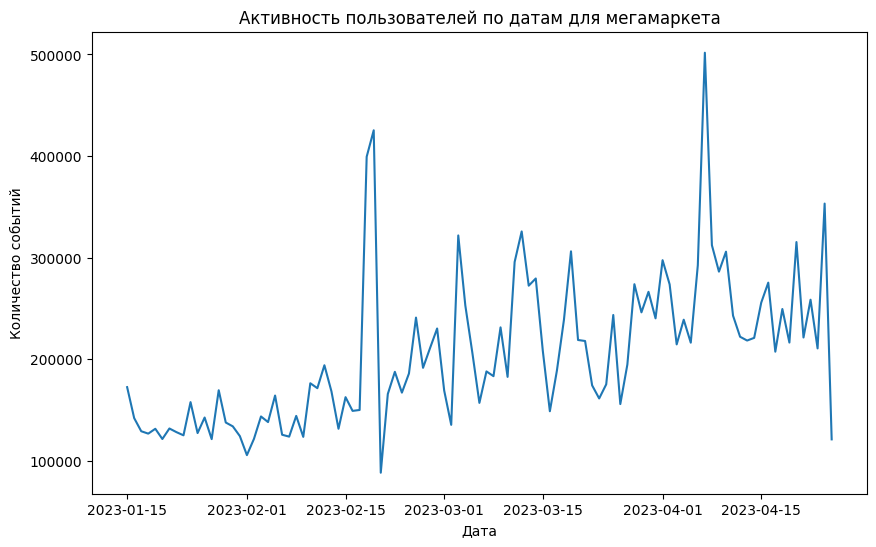

In [39]:
plt.figure(figsize=(10, 6))
smm_train_data['timestamp'].dt.date.value_counts().sort_index().plot()
plt.title(f'Активность пользователей по датам для мегамаркета')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

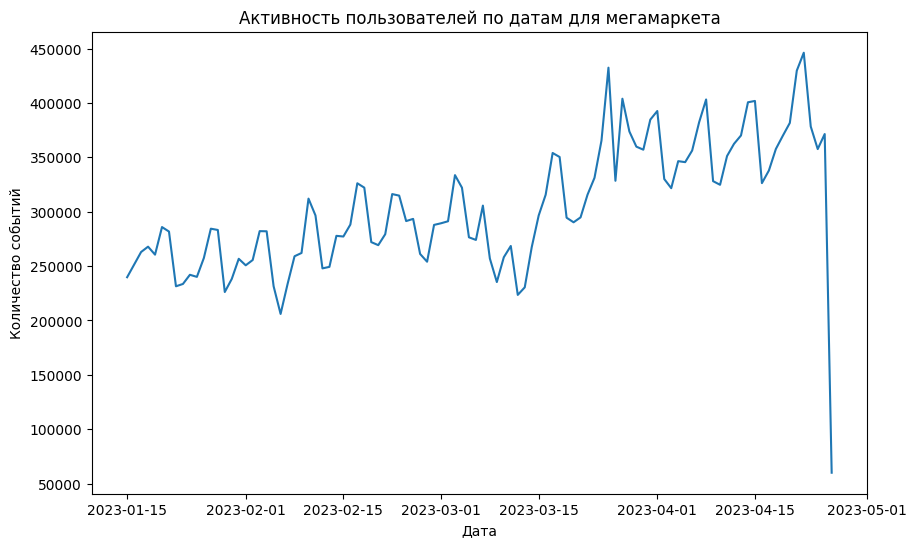

In [40]:
plt.figure(figsize=(10, 6))
zvuk_train_data['timestamp'].dt.date.value_counts().sort_index().plot()
plt.title(f'Активность пользователей по датам для звук')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

In [46]:
smm_train_data['timestamp'] = pd.to_datetime(smm_train_data['timestamp'], unit='ns')

smm_train_data['day_of_week'] = smm_train_data['timestamp'].dt.dayofweek
smm_train_data['month'] = smm_train_data['timestamp'].dt.month
smm_train_data['week_of_year'] = smm_train_data['timestamp'].dt.isocalendar().week
smm_train_data['is_weekend'] = smm_train_data['day_of_week'].isin([5, 6]).astype(int)
smm_train_data['is_peak_season'] = smm_train_data['month'].isin([2, 4]).astype(int)

Графики зависимости мегамеркета в зависимости от времени

C:\Users\User\AppData\Local\Temp\ipykernel_12360\3037747322.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=smm_train_data, x='day_of_week', palette='viridis')


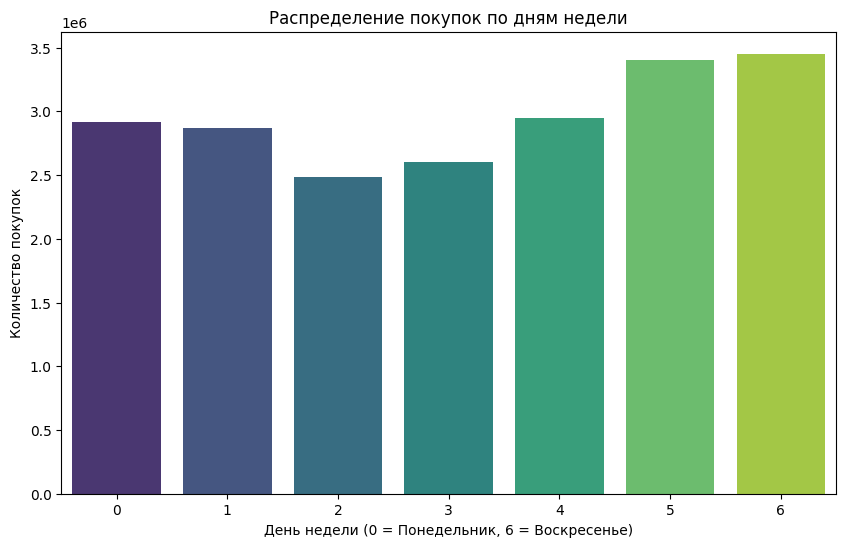

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(data=smm_train_data, x='day_of_week', palette='viridis')
plt.title('Распределение покупок по дням недели')
plt.xlabel('День недели (0 = Понедельник, 6 = Воскресенье)')
plt.ylabel('Количество покупок')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12360\4237208658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=smm_train_data, x='month', palette='coolwarm')


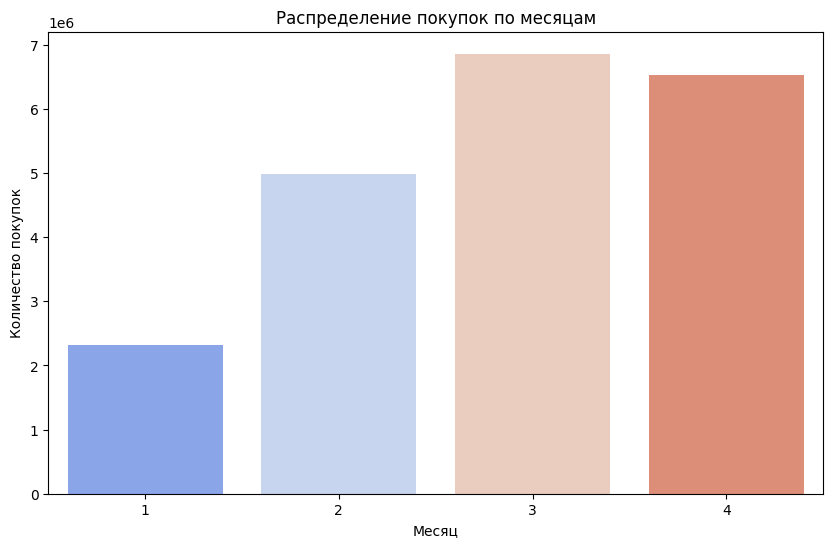

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(data=smm_train_data, x='month', palette='coolwarm')
plt.title('Распределение покупок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество покупок')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12360\465501937.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '192113.63888888888' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  normalized_purchases[0] /= total_weekdays
C:\Users\User\AppData\Local\Temp\ipykernel_12360\465501937.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Будние', 'Выходные'], y=normalized_purchases.values, palette='pastel')


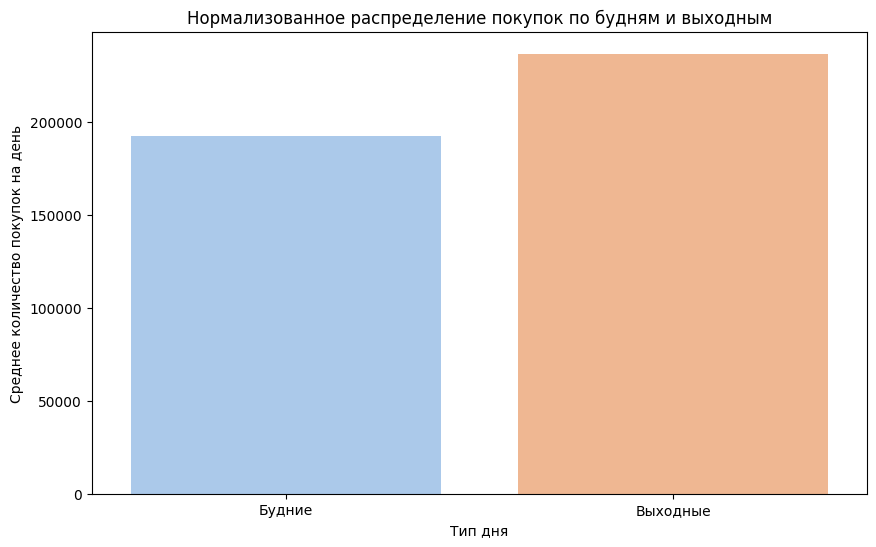

In [53]:
total_weekdays = smm_train_data[smm_train_data['is_weekend'] == 0]['timestamp_datetime'].dt.date.nunique()
total_weekends = smm_train_data[smm_train_data['is_weekend'] == 1]['timestamp_datetime'].dt.date.nunique()

purchases_by_type = smm_train_data.groupby('is_weekend').size()
normalized_purchases = purchases_by_type.copy()
normalized_purchases[0] /= total_weekdays  
normalized_purchases[1] /= total_weekends 

plt.figure(figsize=(10, 6))
sns.barplot(x=['Будние', 'Выходные'], y=normalized_purchases.values, palette='pastel')
plt.title('Нормализованное распределение покупок по будням и выходным')
plt.xlabel('Тип дня')
plt.ylabel('Среднее количество покупок на день')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12360\2996254399.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=smm_train_data, x='week_of_year', palette='viridis', order=sorted(smm_train_data['week_of_year'].unique()))


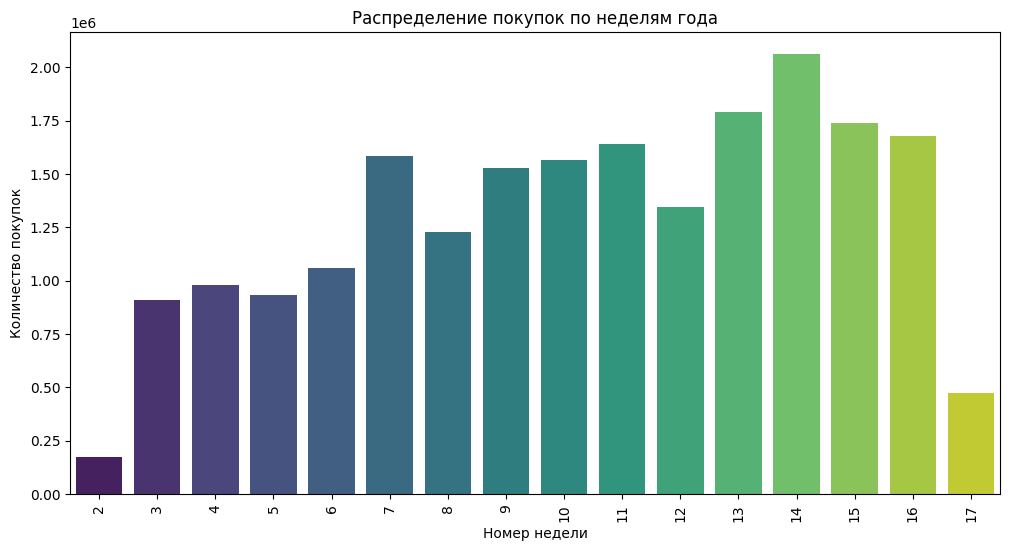

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(data=smm_train_data, x='week_of_year', palette='viridis', order=sorted(smm_train_data['week_of_year'].unique()))
plt.title('Распределение покупок по неделям года')
plt.xlabel('Номер недели')
plt.ylabel('Количество покупок')
plt.xticks(rotation=90)
plt.show()

In [60]:
daily_purchases = smm_train_data.groupby(smm_train_data['timestamp_datetime'].dt.date).size()

february_data = smm_train_data[smm_train_data['month'] == 2]
april_data = smm_train_data[smm_train_data['month'] == 4]

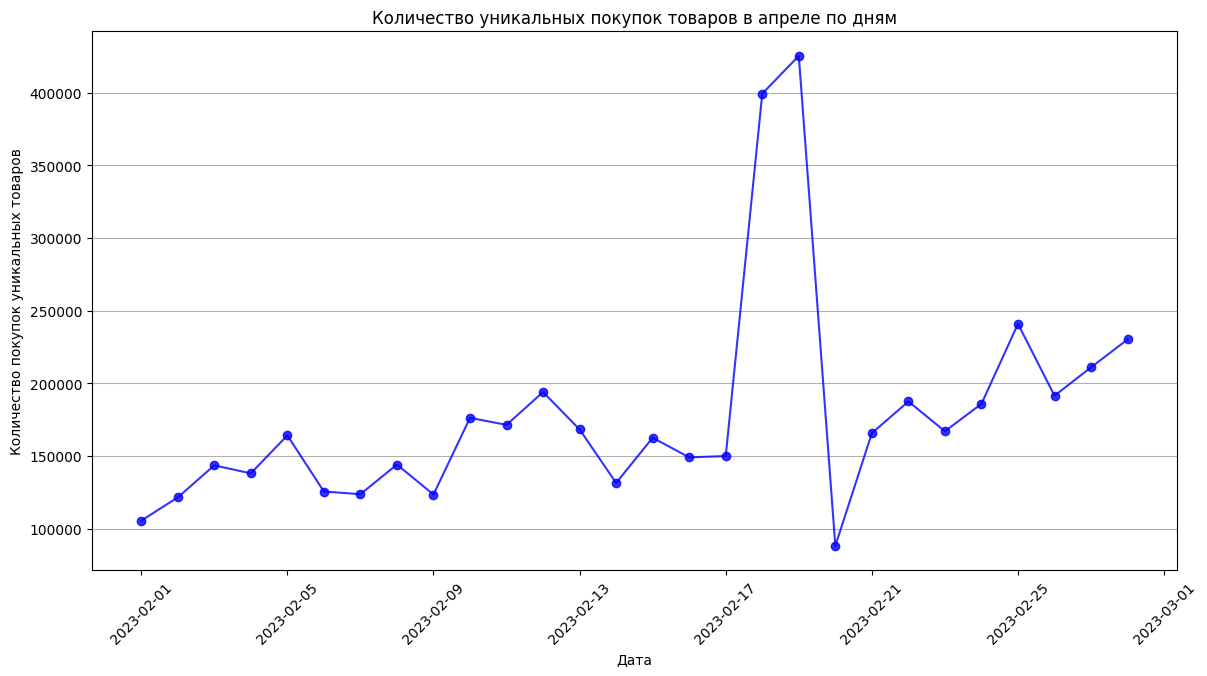

In [112]:
february_items_daily = february_data.groupby(['timestamp_datetime', 'item_id']).size().reset_index(name='count')
february_items_summary = february_items_daily.groupby(february_items_daily['timestamp_datetime'].dt.date)['count'].sum()

plt.figure(figsize=(14, 7))
february_items_summary.plot(kind='line', color='blue', alpha=0.8, marker='o')
plt.title('Количество уникальных покупок товаров в апреле по дням')
plt.xlabel('Дата')
plt.ylabel('Количество покупок уникальных товаров')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Чистим

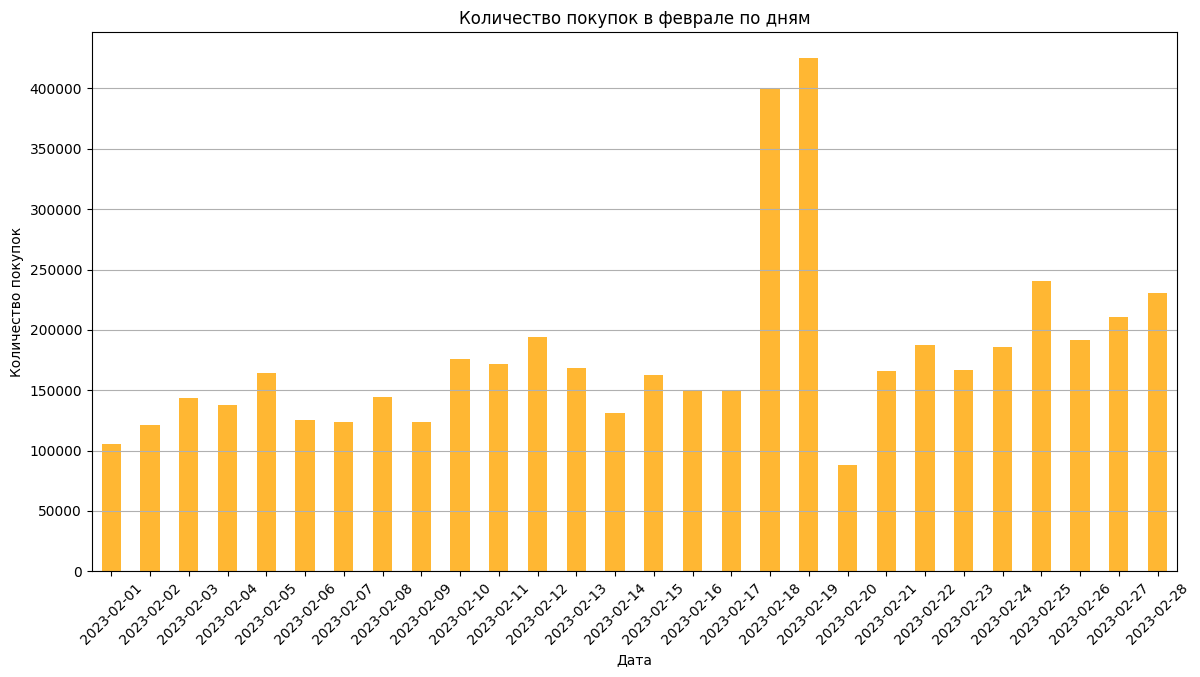

In [66]:
february_daily_purchases = february_data.groupby(february_data['timestamp_datetime'].dt.date).size()

plt.figure(figsize=(14, 7))
february_daily_purchases.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Количество покупок в феврале по дням')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


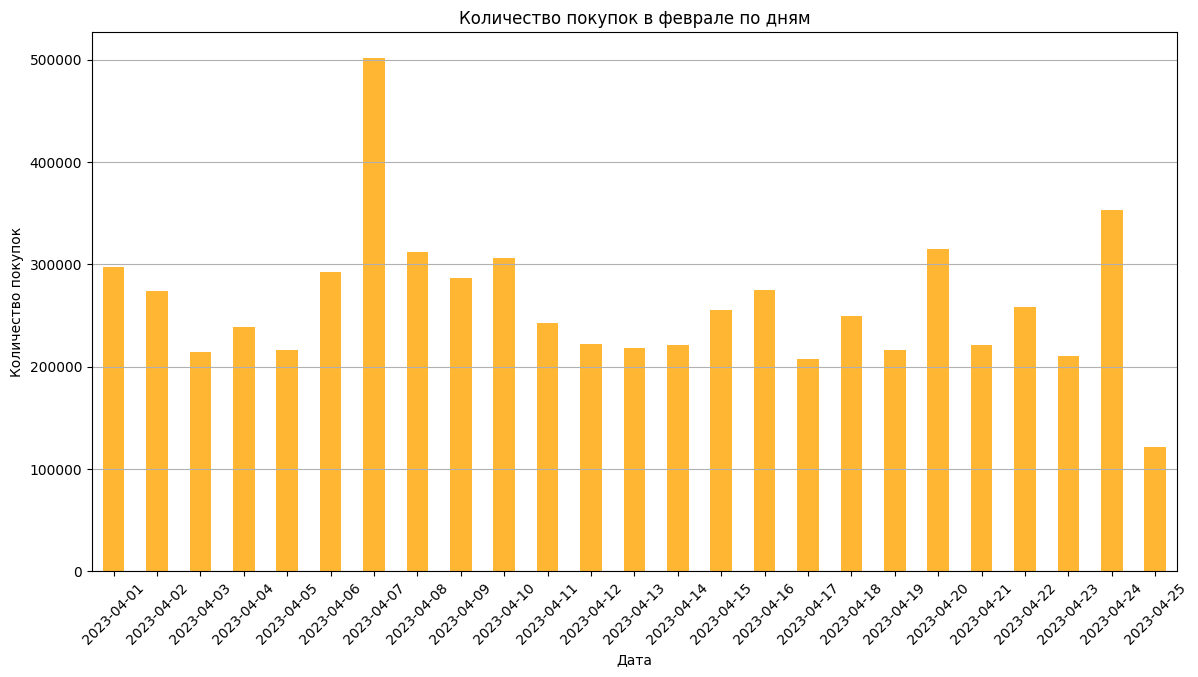

In [68]:
april_data_purchases = april_data.groupby(april_data['timestamp_datetime'].dt.date).size()

plt.figure(figsize=(14, 7))
april_data_purchases.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Количество покупок в феврале по дням')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


По items


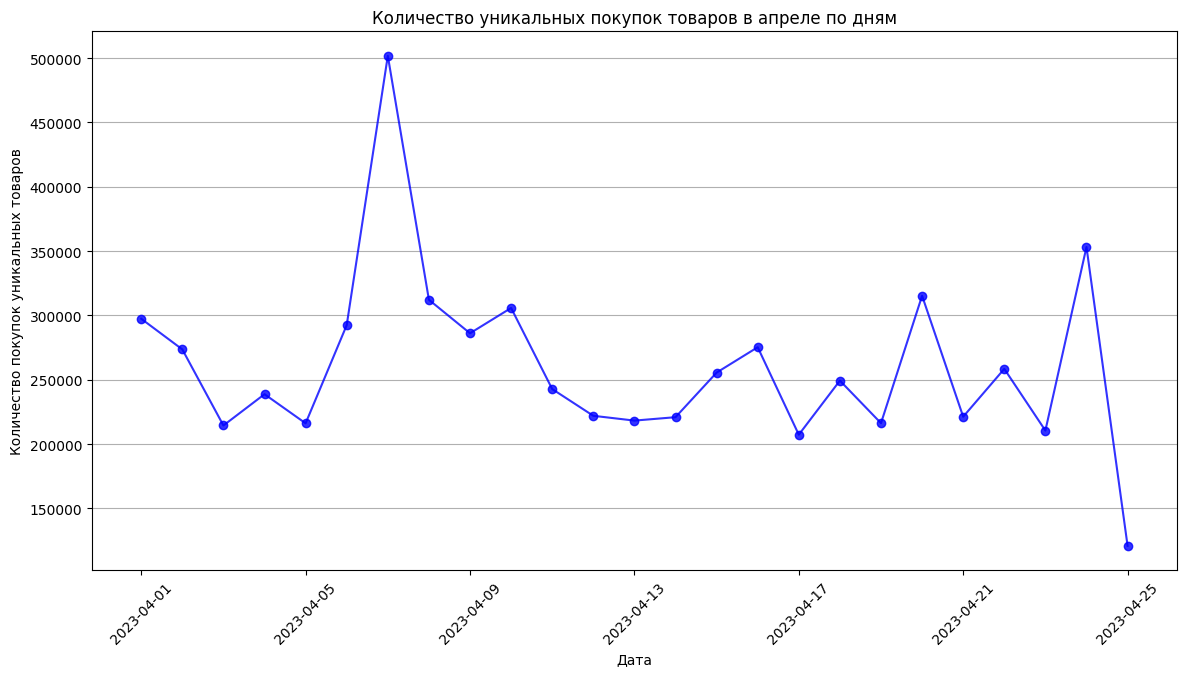

In [72]:
april_items_daily = april_data.groupby(['timestamp_datetime', 'item_id']).size().reset_index(name='count')
april_items_summary = april_items_daily.groupby(april_items_daily['timestamp_datetime'].dt.date)['count'].sum()

plt.figure(figsize=(14, 7))
april_items_summary.plot(kind='line', color='blue', alpha=0.8, marker='o')
plt.title('Количество уникальных покупок товаров в апреле по дням')
plt.xlabel('Дата')
plt.ylabel('Количество покупок уникальных товаров')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [126]:
february_data

,user_id,item_id,timestamp,rating,Time,timestamp_datetime,day_of_week,month,week_of_year,is_weekend,is_peak_season
14163153,7482827,117363,2023-04-01 00:00:00.559,1.554808,2023-04-01 00:00:00.559,2023-04-01 00:00:00.559,5,4,13,1,1
14163154,4889177,49013,2023-04-01 00:00:00.673,1.554808,2023-04-01 00:00:00.673,2023-04-01 00:00:00.673,5,4,13,1,1
14163155,2794097,96853,2023-04-01 00:00:02.101,1.554808,2023-04-01 00:00:02.101,2023-04-01 00:00:02.101,5,4,13,1,1
14163156,7482827,139636,2023-04-01 00:00:05.827,1.554808,2023-04-01 00:00:05.827,2023-04-01 00:00:05.827,5,4,13,1,1
14163157,3087621,146999,2023-04-01 00:00:08.857,1.554808,2023-04-01 00:00:08.857,2023-04-01 00:00:08.857,5,4,13,1,1
...,...,...,...,...,...,...,...,...,...,...,...
20689585,5017818,36122,2023-04-25 09:14:17.370,1.554808,2023-04-25 09:14:17.370,2023-04-25 09:14:17.370,1,4,17,0,1
20689586,8987011,135024,2023-04-25 09:14:17.378,1.554808,2023-04-25 09:14:17.378,2023-04-25 09:14:17.378,1,4,17,0,1
20689587,9006098,13386,2023-04-25 09:14:17.383,1.554808,2023-04-25 09:14:17.383,2023-04-25 09:14:17.383,1,4,17,0,1
20689588,1738180,154443,2023-04-25 09:14:18.635,1.554808,2023-04-25 09:14:18.635,2023-04-25 09:14:18.635,1,4,17,0,1


По звуку и по дням

In [130]:
smm_train_data['timestamp_datetime'] = pd.to_datetime(smm_train_data['timestamp'], unit='ns')

february_specific_days = smm_train_data[
    (smm_train_data['timestamp_datetime'].dt.date == pd.to_datetime('2023-02-18').date()) |
    (smm_train_data['timestamp_datetime'].dt.date == pd.to_datetime('2023-02-19').date())
]

april_specific_day = smm_train_data[smm_train_data['timestamp_datetime'].dt.date == pd.to_datetime('2023-04-06').date()]

february_users = set(february_specific_days['user_id'].unique())
april_users = set(april_specific_day['user_id'].unique())

intersection_users = february_users.intersection(april_users)

print(f"Количество уникальных пользователей за 18-19 февраля: {len(february_users)}")
print(f"Количество уникальных пользователей за 6 апреля: {len(april_users)}")
print(f"Количество пользователей, которые покупали товары в оба периода: {len(intersection_users)}")

print(f"Пересекающиеся user_id: {intersection_users}")


Количество уникальных пользователей за 18-19 февраля: 65551
Количество уникальных пользователей за 6 апреля: 46994
Количество пользователей, которые покупали товары в оба периода: 20246
Пересекающиеся user_id: {9437186, 1703943, 1966094, 6553618, 1966110, 2359341, 5242927, 8912944, 4980788, 8912950, 1703994, 4718651, 5767232, 8257603, 8650841, 2490460, 7864416, 8519778, 6684798, 1441923, 9437315, 2359429, 6291591, 2621593, 2621599, 8519839, 2883746, 7602341, 4194477, 9830577, 1835187, 3932341, 9044150, 8126652, 6815937, 4456642, 9175239, 8519887, 4194519, 9175259, 8913115, 4980963, 9175268, 3145959, 3145960, 2228457, 5243114, 1310974, 8913159, 3539216, 5898520, 6684955, 8257820, 6291769, 7733574, 4718924, 1442140, 2883945, 3932523, 8651118, 2228594, 4063606, 6553981, 4850049, 8782222, 1180047, 1966480, 3801486, 9961874, 7995798, 8257944, 9306533, 5243306, 9830846, 6816192, 6685132, 3801552, 9306596, 1704432, 7602674, 6029810, 8520184, 5374459, 1311235, 4588046, 3932695, 7209501, 288413

In [73]:
zvuk_train_data['timestamp_datetime'] = pd.to_datetime(zvuk_train_data['timestamp'], unit='ns')
zvuk_train_data['hour'] = zvuk_train_data['timestamp_datetime'].dt.hour
zvuk_train_data['day_of_week'] = zvuk_train_data['timestamp_datetime'].dt.dayofweek
zvuk_train_data['month'] = zvuk_train_data['timestamp_datetime'].dt.month

In [ ]:
zvuk_train_data['timestamp_datetime'] 

C:\Users\User\AppData\Local\Temp\ipykernel_12360\555174891.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zvuk_train_data, x='hour', palette='viridis')


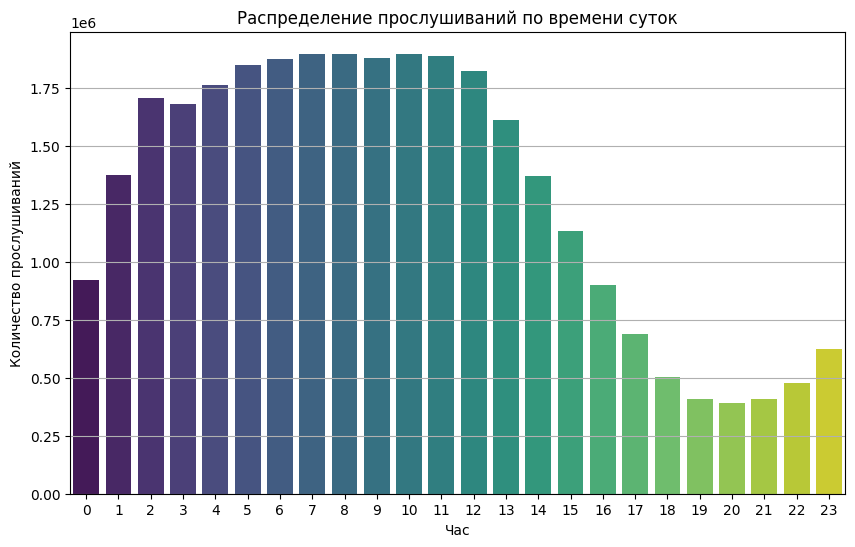

In [74]:
plt.figure(figsize=(10, 6))
sns.countplot(data=zvuk_train_data, x='hour', palette='viridis')
plt.title('Распределение прослушиваний по времени суток')
plt.xlabel('Час')
plt.ylabel('Количество прослушиваний')
plt.grid(axis='y')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12360\3894819400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=zvuk_train_data, x='day_of_week', palette='coolwarm')


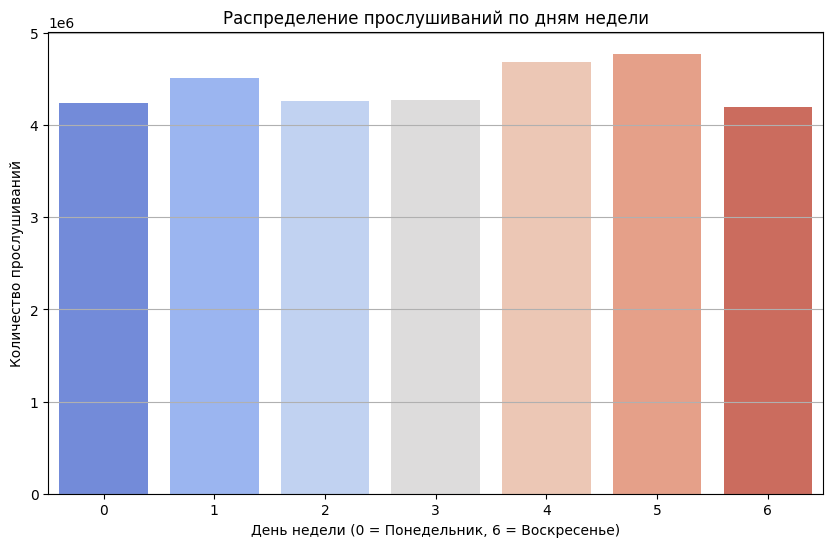

In [75]:
plt.figure(figsize=(10, 6))
sns.countplot(data=zvuk_train_data, x='day_of_week', palette='coolwarm')
plt.title('Распределение прослушиваний по дням недели')
plt.xlabel('День недели (0 = Понедельник, 6 = Воскресенье)')
plt.ylabel('Количество прослушиваний')
plt.grid(axis='y')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12360\1087068858.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.index, y=top_items.values, palette='pastel')


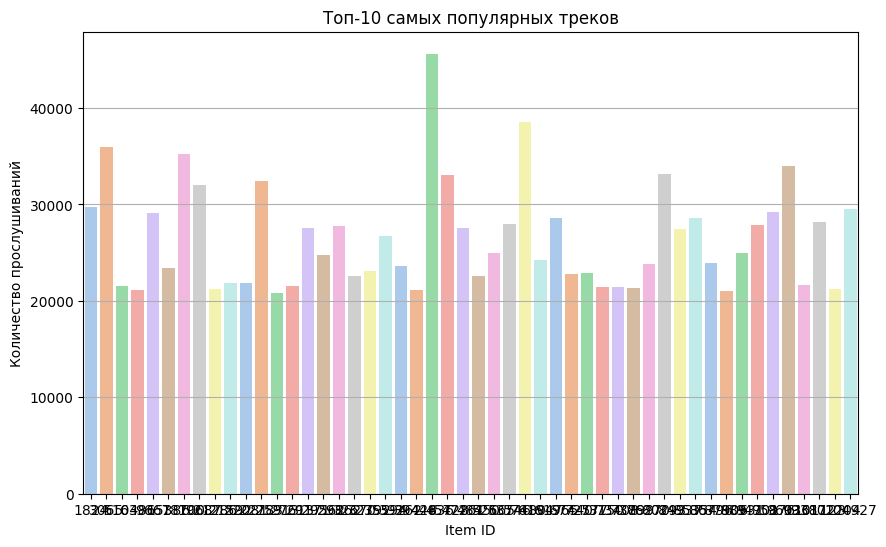

In [81]:
top_items = zvuk_train_data['item_id'].value_counts().head(50)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_items.index, y=top_items.values, palette='pastel')
plt.title('Топ-10 самых популярных треков')
plt.xlabel('Item ID')
plt.ylabel('Количество прослушиваний')
plt.grid(axis='y')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12360\2777663878.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=not_top_items.index, y=not_top_items.values, palette='pastel')


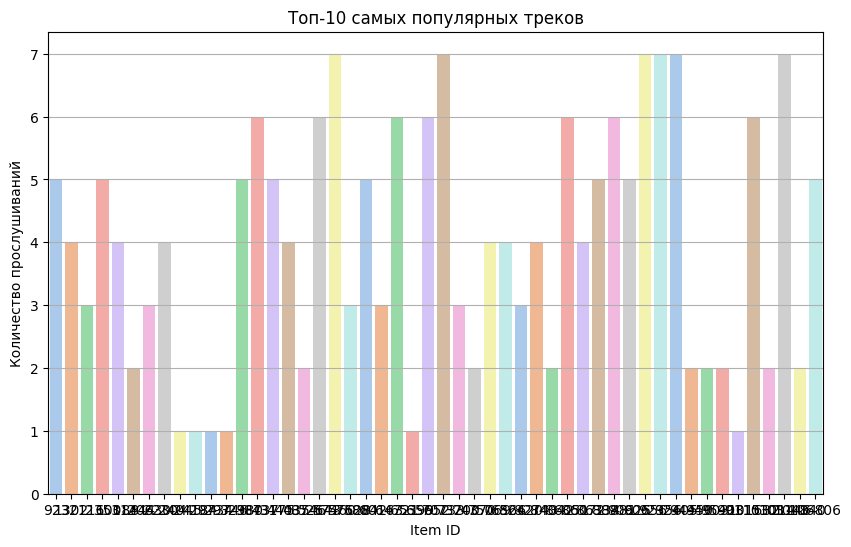

In [77]:
not_top_items = zvuk_train_data['item_id'].value_counts().tail(50)
plt.figure(figsize=(10, 6))
sns.barplot(x=not_top_items.index, y=not_top_items.values, palette='pastel')
plt.title('Топ-50 самых  не популярных треков')
plt.xlabel('Item ID')
plt.ylabel('Количество прослушиваний')
plt.grid(axis='y')
plt.show()

In [105]:
daily_purchases = zvuk_train_data.groupby(zvuk_train_data['timestamp_datetime'].dt.date).size()

february = zvuk_train_data[zvuk_train_data['month'] == 2]
april = zvuk_train_data[zvuk_train_data['month'] == 4]
january = zvuk_train_data[zvuk_train_data['month'] == 1]
march = zvuk_train_data[zvuk_train_data['month'] == 3]

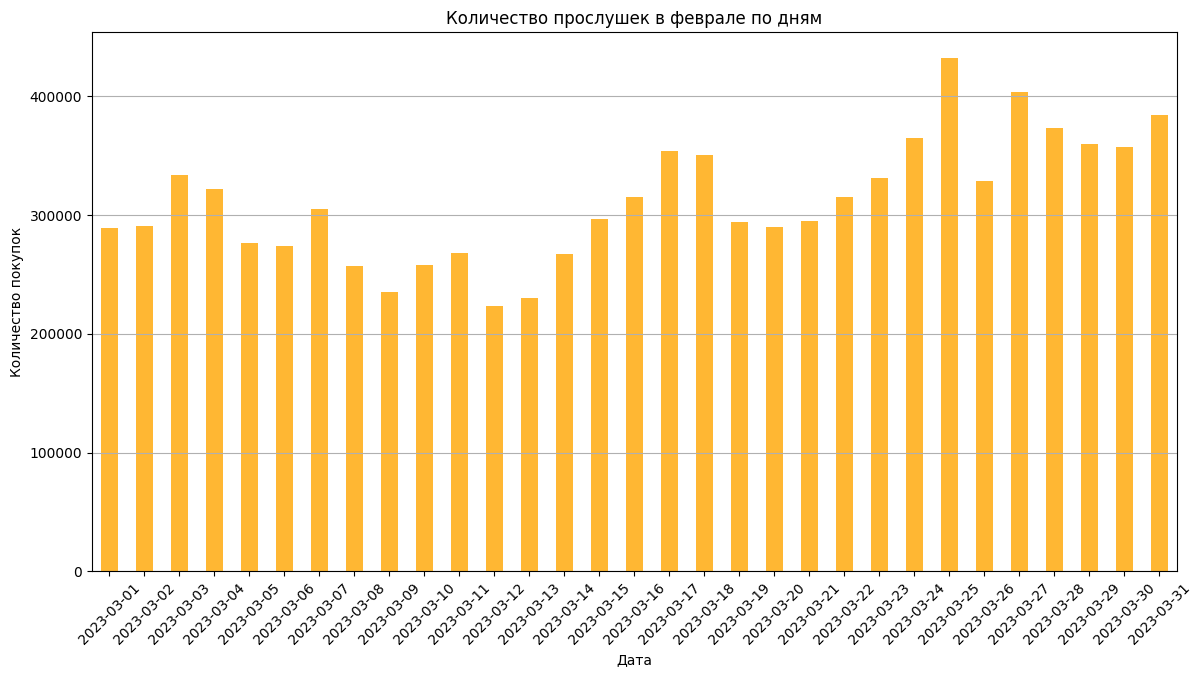

In [111]:
march_gb = march.groupby(march['timestamp_datetime'].dt.date).size()

plt.figure(figsize=(14, 7))
march_gb.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Количество прослушек в феврале по дням')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


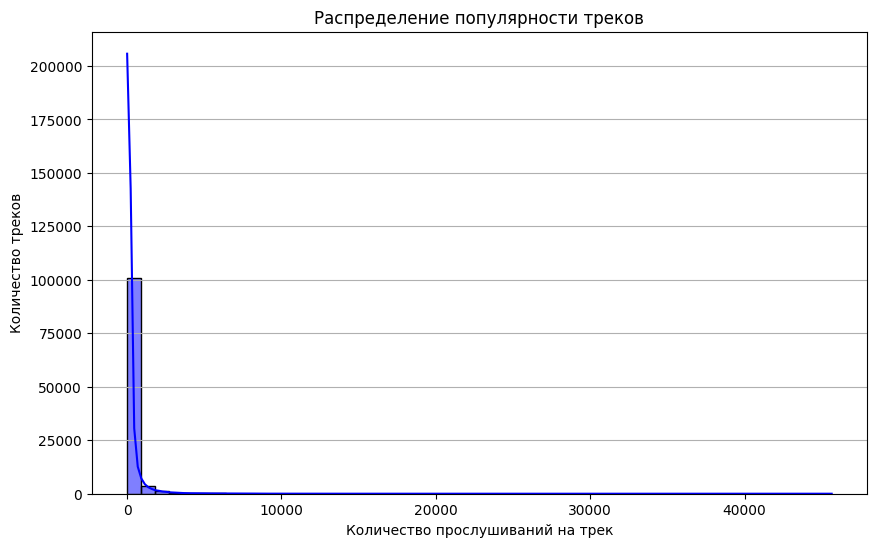

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(zvuk_train_data['item_id'].value_counts(), bins=50, kde=True, color='blue')
plt.title('Распределение популярности треков')
plt.xlabel('Количество прослушиваний на трек')
plt.ylabel('Количество треков')
plt.grid(axis='y')
plt.show()

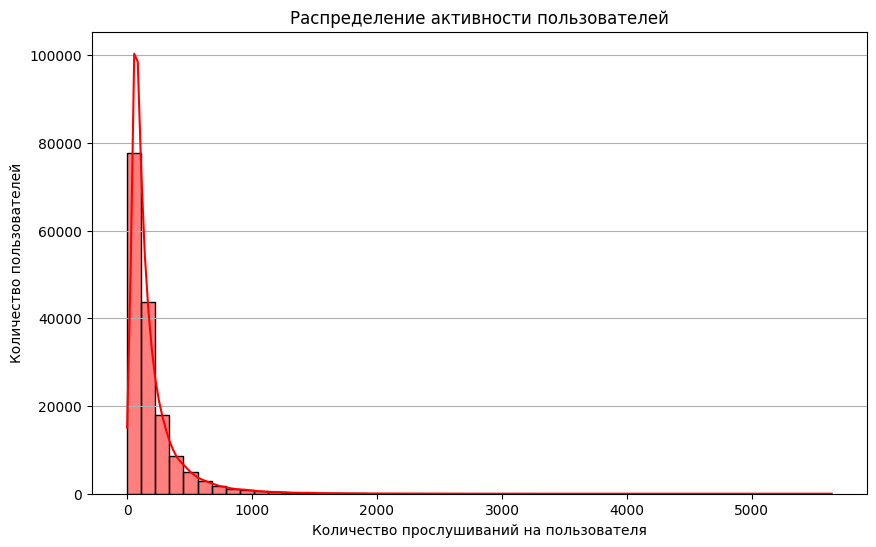

In [79]:
user_activity = zvuk_train_data['user_id'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=50, kde=True, color='red')
plt.title('Распределение активности пользователей')
plt.xlabel('Количество прослушиваний на пользователя')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.show()

In [103]:
smm_train_data['rating'].describe()

count    2.068959e+07
mean     3.304713e+00
std      1.375845e+01
min      1.554808e+00
25%      1.554808e+00
50%      1.554808e+00
75%      2.802427e+00
max      1.964221e+04
Name: rating, dtype: float64

In [96]:
percentile_95 = np.percentile(smm_train_data['rating'], 95)
percentile_99 = np.percentile(smm_train_data['rating'], 99)
print(f"95-й перцентиль: {percentile_95}")
print(f"99-й перцентиль: {percentile_99}")


95-й перцентиль: 8.40727980237141
99-й перцентиль: 28.0242660079047


In [97]:
filtered_data = smm_train_data[smm_train_data['rating'] <= 28.02]

In [98]:
filtered_data

,user_id,item_id,timestamp,rating,Time,timestamp_datetime,day_of_week,month,week_of_year,is_weekend,is_peak_season
0,2353151,149597,2023-01-15 00:00:03.033,1.554808,2023-01-15 00:00:03.033,2023-01-15 00:00:03.033,6,1,2,1,0
1,9824229,90964,2023-01-15 00:00:03.105,1.554808,2023-01-15 00:00:03.105,2023-01-15 00:00:03.105,6,1,2,1,0
2,6001776,86260,2023-01-15 00:00:10.376,1.554808,2023-01-15 00:00:10.376,2023-01-15 00:00:10.376,6,1,2,1,0
3,9821399,104024,2023-01-15 00:00:10.924,1.554808,2023-01-15 00:00:10.924,2023-01-15 00:00:10.924,6,1,2,1,0
4,9280991,8232,2023-01-15 00:00:14.425,1.554808,2023-01-15 00:00:14.425,2023-01-15 00:00:14.425,6,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
20689585,5017818,36122,2023-04-25 09:14:17.370,1.554808,2023-04-25 09:14:17.370,2023-04-25 09:14:17.370,1,4,17,0,1
20689586,8987011,135024,2023-04-25 09:14:17.378,1.554808,2023-04-25 09:14:17.378,2023-04-25 09:14:17.378,1,4,17,0,1
20689587,9006098,13386,2023-04-25 09:14:17.383,1.554808,2023-04-25 09:14:17.383,2023-04-25 09:14:17.383,1,4,17,0,1
20689588,1738180,154443,2023-04-25 09:14:18.635,1.554808,2023-04-25 09:14:18.635,2023-04-25 09:14:18.635,1,4,17,0,1


Активн6ость пользователей и айтемов

In [ ]:
zvuk_train_data['rating'].describe()

count    3.095706e+07
mean     2.798804e+00
std      8.532199e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.811700e+04
Name: rating, dtype: float64

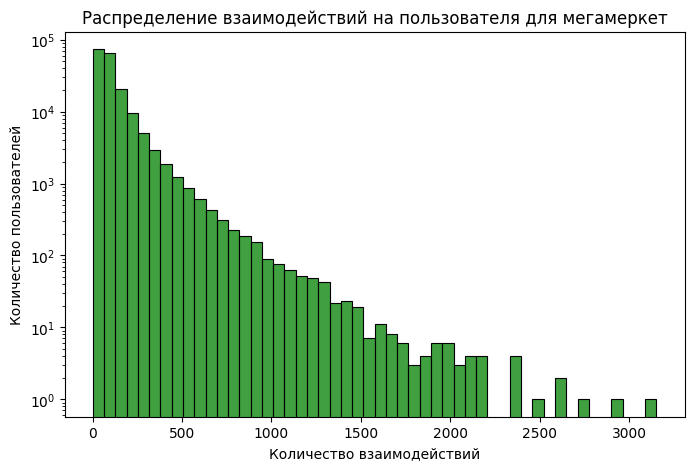

In [41]:
user_interactions = smm_train_data['user_id'].value_counts()
plt.figure(figsize=(8, 5))
sns.histplot(user_interactions, kde=False, bins=50, color='green')
plt.title(f'Распределение взаимодействий на пользователя для мегамеркет')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество пользователей')
plt.yscale('log')  
plt.show()

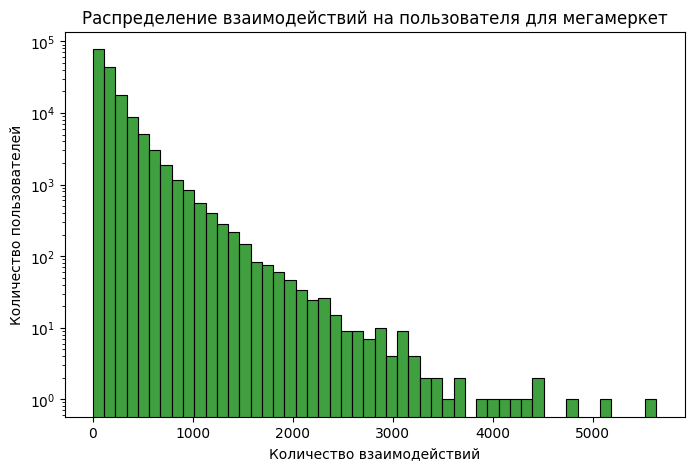

In [42]:
user_interactions = zvuk_train_data['user_id'].value_counts()
plt.figure(figsize=(8, 5))
sns.histplot(user_interactions, kde=False, bins=50, color='green')
plt.title(f'Распределение взаимодействий на пользователя для мегамеркет')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество пользователей')
plt.yscale('log')  
plt.show()

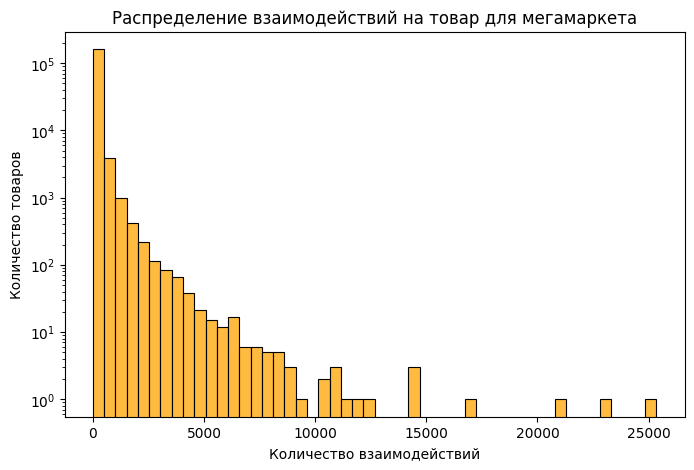

In [43]:
item_interactions = smm_train_data['item_id'].value_counts()
plt.figure(figsize=(8, 5))
sns.histplot(item_interactions, kde=False, bins=50, color='orange')
plt.title(f'Распределение взаимодействий на товар для мегамаркета')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество товаров')
plt.yscale('log')  
plt.show()

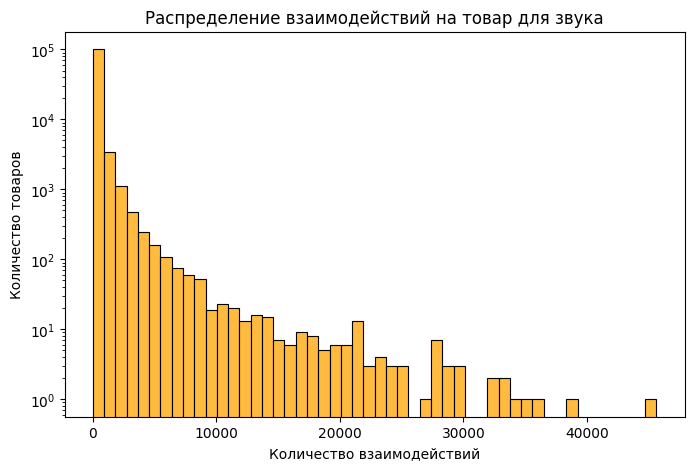

In [44]:
item_interactions = zvuk_train_data['item_id'].value_counts()
plt.figure(figsize=(8, 5))
sns.histplot(item_interactions, kde=False, bins=50, color='orange')
plt.title(f'Распределение взаимодействий на товар для звука')
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество товаров')
plt.yscale('log')  
plt.show()

### Что с rating

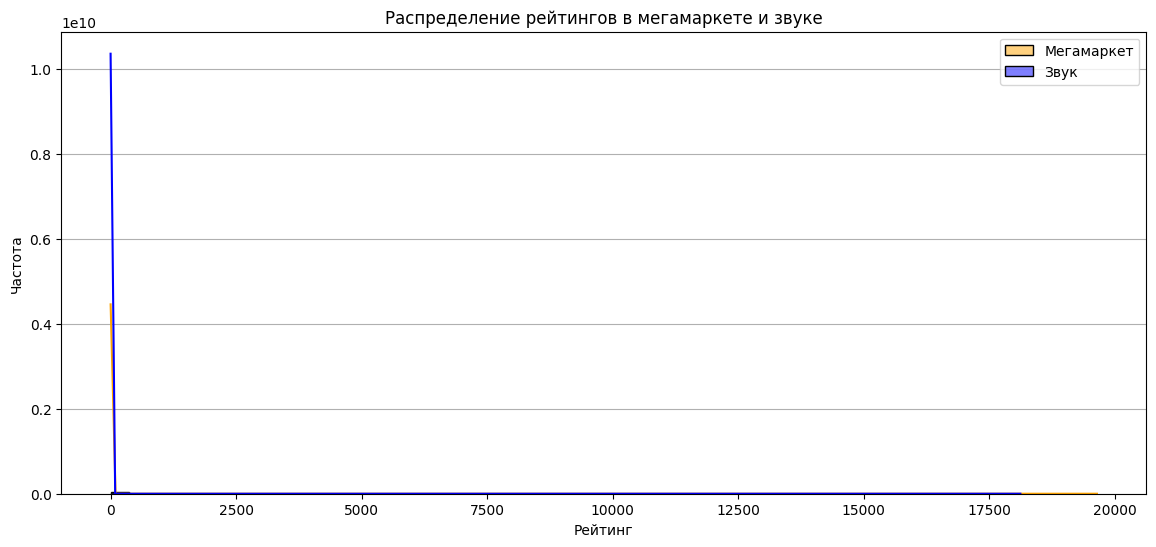

In [82]:
plt.figure(figsize=(14, 6))
sns.histplot(smm_train_data['rating'], bins=50, kde=True, color='orange', label='Мегамаркет')
sns.histplot(zvuk_train_data['rating'], bins=50, kde=True, color='blue', label='Звук')
plt.title('Распределение рейтингов в мегамаркете и звуке')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y')
plt.show()


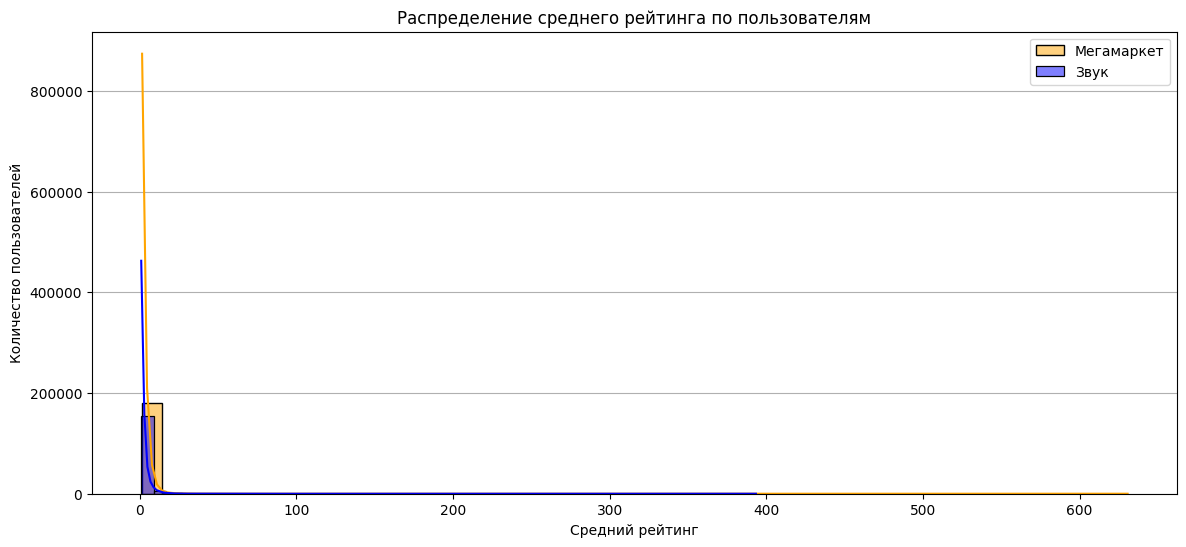

In [84]:
# Средний рейтинг для каждого пользователя
avg_user_rating_megamarket = smm_train_data.groupby('user_id')['rating'].mean()
avg_user_rating_zvuk = zvuk_train_data.groupby('user_id')['rating'].mean()

plt.figure(figsize=(14, 6))
sns.histplot(avg_user_rating_megamarket, bins=50, kde=True, color='orange', label='Мегамаркет')
sns.histplot(avg_user_rating_zvuk, bins=50, kde=True, color='blue', label='Звук')
plt.title('Распределение среднего рейтинга по пользователям')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(axis='y')
plt.show()


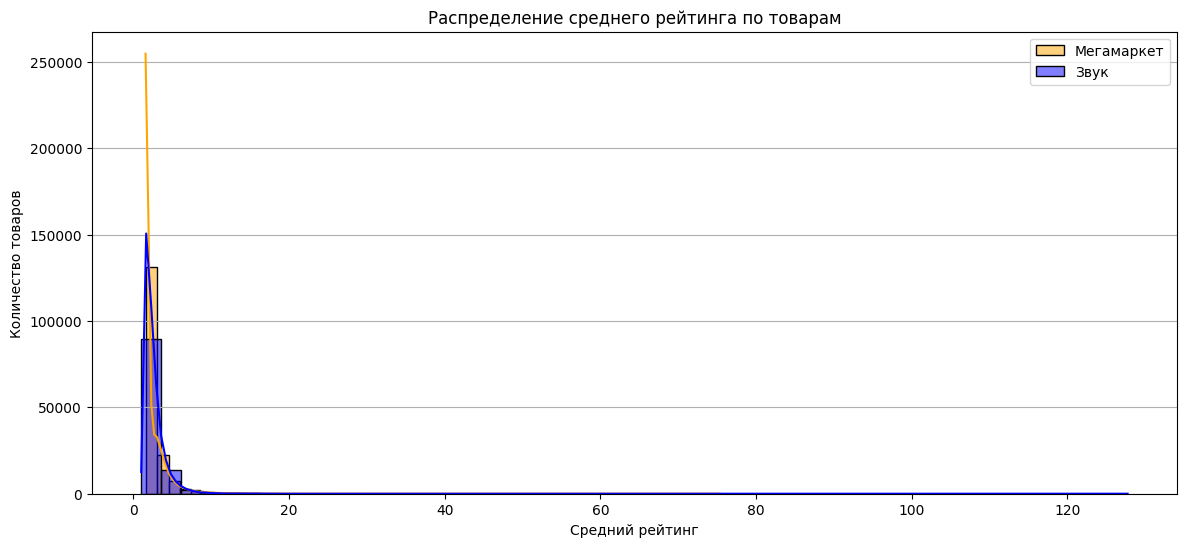

In [86]:
# Средний рейтинг для каждого товара
avg_item_rating_megamarket = smm_train_data.groupby('item_id')['rating'].mean()
avg_item_rating_zvuk = zvuk_train_data.groupby('item_id')['rating'].mean()

plt.figure(figsize=(14, 6))
sns.histplot(avg_item_rating_megamarket, bins=50, kde=True, color='orange', label='Мегамаркет')
sns.histplot(avg_item_rating_zvuk, bins=50, kde=True, color='blue', label='Звук')
plt.title('Распределение среднего рейтинга по товарам')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество товаров')
plt.legend()
plt.grid(axis='y')
plt.show()


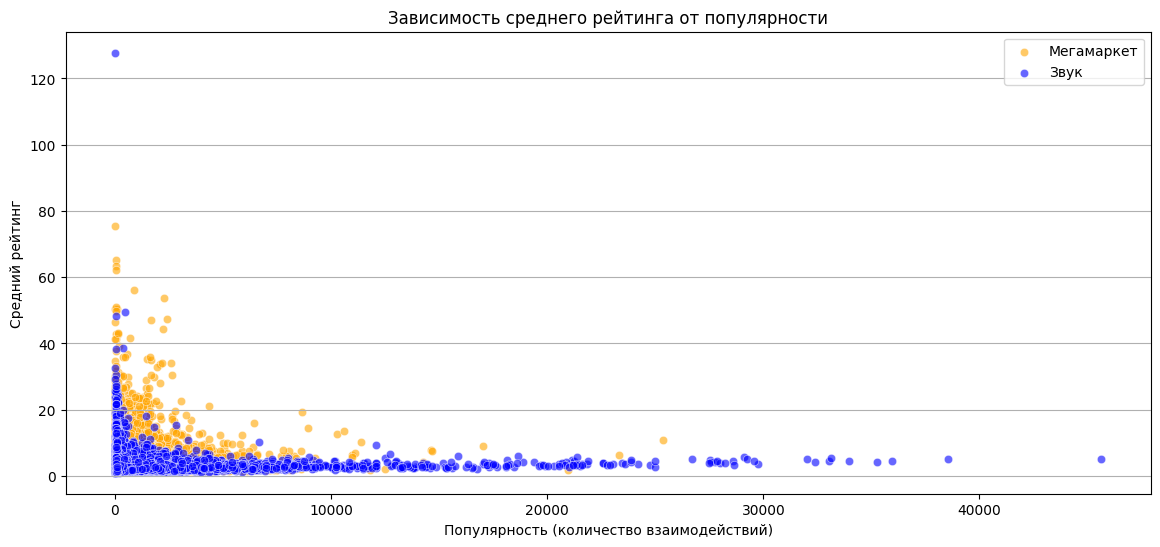

In [93]:
# Проверим, что временные метки преобразованы
smm_train_data['timestamp_datetime'] = pd.to_datetime(smm_train_data['timestamp'], unit='ns')
zvuk_train_data['timestamp_datetime'] = pd.to_datetime(zvuk_train_data['timestamp'], unit='ns')

# 1. Рассчитаем популярность товаров как количество взаимодействий
megamarket_popularity = smm_train_data.groupby('item_id').size()
zvuk_popularity = zvuk_train_data.groupby('item_id').size()

# 2. Рассчитаем средний рейтинг для каждого товара
megamarket_avg_rating = smm_train_data.groupby('item_id')['rating'].mean()
zvuk_avg_rating = zvuk_train_data.groupby('item_id')['rating'].mean()

megamarket_analysis = pd.DataFrame({
    'popularity': megamarket_popularity,
    'avg_rating': megamarket_avg_rating
}).dropna()

zvuk_analysis = pd.DataFrame({
    'popularity': zvuk_popularity,
    'avg_rating': zvuk_avg_rating
}).dropna()


plt.figure(figsize=(14, 6))
sns.scatterplot(data=megamarket_analysis, x='popularity', y='avg_rating', color='orange', alpha=0.6, label='Мегамаркет')
sns.scatterplot(data=zvuk_analysis, x='popularity', y='avg_rating', color='blue', alpha=0.6, label='Звук')
plt.title('Зависимость среднего рейтинга от популярности')
plt.xlabel('Популярность (количество взаимодействий)')
plt.ylabel('Средний рейтинг')
plt.legend()
plt.grid(axis='y')
plt.show()


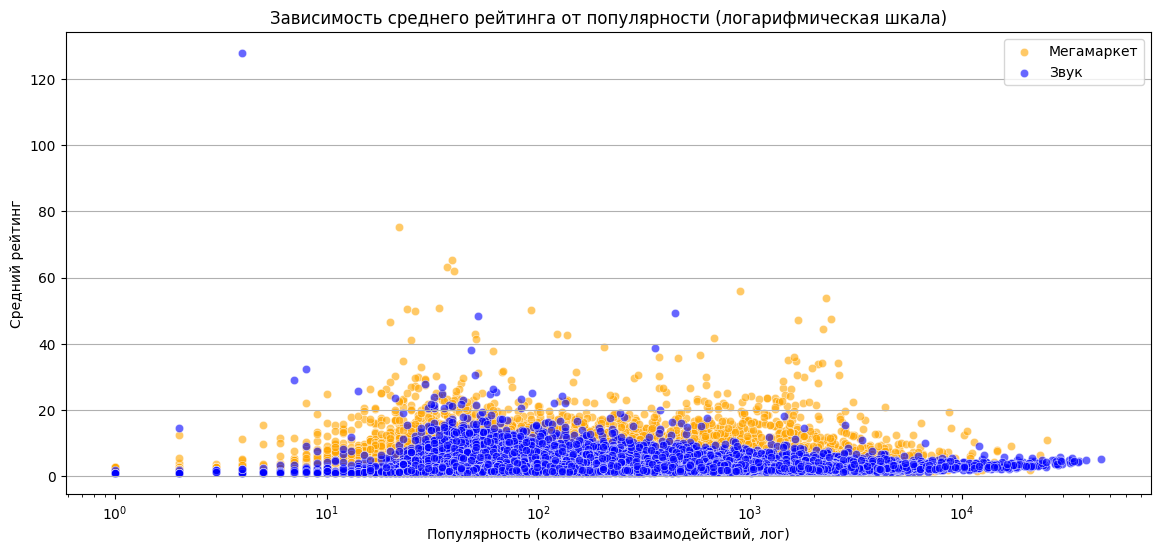

In [94]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=megamarket_analysis, x='popularity', y='avg_rating', color='orange', alpha=0.6, label='Мегамаркет')
sns.scatterplot(data=zvuk_analysis, x='popularity', y='avg_rating', color='blue', alpha=0.6, label='Звук')
plt.xscale('log')
plt.title('Зависимость среднего рейтинга от популярности (логарифмическая шкала)')
plt.xlabel('Популярность (количество взаимодействий, лог)')
plt.ylabel('Средний рейтинг')
plt.legend()
plt.grid(axis='y')
plt.show()

In [25]:
zvuk_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24458793 entries, 0 to 24458792
Data columns (total 4 columns):
 #   Column     Dtype
---  ------     -----
 0   user_id    int64
 1   timestamp  int64
 2   item_id    int64
 3   rating     int64
dtypes: int64(4)
memory usage: 746.4 MB


In [24]:
smm_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18601324 entries, 0 to 18601323
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   item_id    int64  
 2   timestamp  int64  
 3   rating     float64
dtypes: float64(1), int64(3)
memory usage: 567.7 MB


кол-во уникальных айдишников

In [90]:
print(zvuk_train_data.user_id.nunique())
print(smm_train_data.item_id.nunique())

161988
167512


## Чистим

In [91]:
zvuk_train_data.head()

,user_id,timestamp,item_id,rating,timestamp_datetime,hour,day_of_week,month
0,6486258,2023-01-15 00:00:00.074,75474,1,2023-01-15 00:00:00.074,0,6,1
1,7436216,2023-01-15 00:00:01.368,24228,5,2023-01-15 00:00:01.368,0,6,1
2,1736489,2023-01-15 00:00:01.516,13113,3,2023-01-15 00:00:01.516,0,6,1
3,4976699,2023-01-15 00:00:03.052,76029,5,2023-01-15 00:00:03.052,0,6,1
4,4976699,2023-01-15 00:00:03.056,105990,1,2023-01-15 00:00:03.056,0,6,1


In [92]:
smm_train_data.head()

,user_id,item_id,timestamp,rating,Time,timestamp_datetime,day_of_week,month,week_of_year,is_weekend,is_peak_season
0,2353151,149597,2023-01-15 00:00:03.033,1.554808,2023-01-15 00:00:03.033,2023-01-15 00:00:03.033,6,1,2,1,0
1,9824229,90964,2023-01-15 00:00:03.105,1.554808,2023-01-15 00:00:03.105,2023-01-15 00:00:03.105,6,1,2,1,0
2,6001776,86260,2023-01-15 00:00:10.376,1.554808,2023-01-15 00:00:10.376,2023-01-15 00:00:10.376,6,1,2,1,0
3,9821399,104024,2023-01-15 00:00:10.924,1.554808,2023-01-15 00:00:10.924,2023-01-15 00:00:10.924,6,1,2,1,0
4,9280991,8232,2023-01-15 00:00:14.425,1.554808,2023-01-15 00:00:14.425,2023-01-15 00:00:14.425,6,1,2,1,0


# Pipeline and baseline

In [10]:
svd = TruncatedSVD(n_components=50, random_state=42)
user_matrix = svd.fit_transform(user_item_sparse_matrix)
item_matrix = svd.components_

NameError: name 'user_item_sparse_matrix' is not defined